In [3]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import VarianceThreshold

import plotly.express as px
import geopandas as gpd

from metaphone import doublemetaphone

## Loading Datasets

In [4]:
movies_df = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t',names=['Wikipedia_ID','Freebase_ID','Name','Release_date','Box_office_revenues','Runtime','Languages','Country','Genres'])
movies_df.head()

,Wikipedia_ID,Freebase_ID,Name,Release_date,Box_office_revenues,Runtime,Languages,Country,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
character_df = pd.read_csv('MovieSummaries/character.metadata.tsv',sep='\t', names=['Wikipedia_ID','Freebase_ID','Release_date','Character_name','Actor_DOB',
                                                                                    'Sex','Height','Ethnicity','Actor_name','Actor_age','Freebase_character_map'
                                                                                    ,'?','??'])

In [6]:
# Cleaning Languages, Country and Genres Columns

def str_dict_to_values(dict_in_str: str)->list[str]:
    
    if dict_in_str is None:  
        return []
    dict_ = json.loads(dict_in_str)
    values = list(dict_.values())
    return values

movies_df['Languages'] = movies_df['Languages'].apply(str_dict_to_values)
movies_df['Country'] = movies_df['Country'].apply(str_dict_to_values)
movies_df['Genres'] = movies_df['Genres'].apply(str_dict_to_values)

## Handling NaN values

/var/folders/qy/f2gycl5x4rz0443jgmxn93_80000gn/T/ipykernel_53224/3547849048.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
/var/folders/qy/f2gycl5x4rz0443jgmxn93_80000gn/T/ipykernel_53224/3547849048.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(missing_values_character.index, rotation=90)


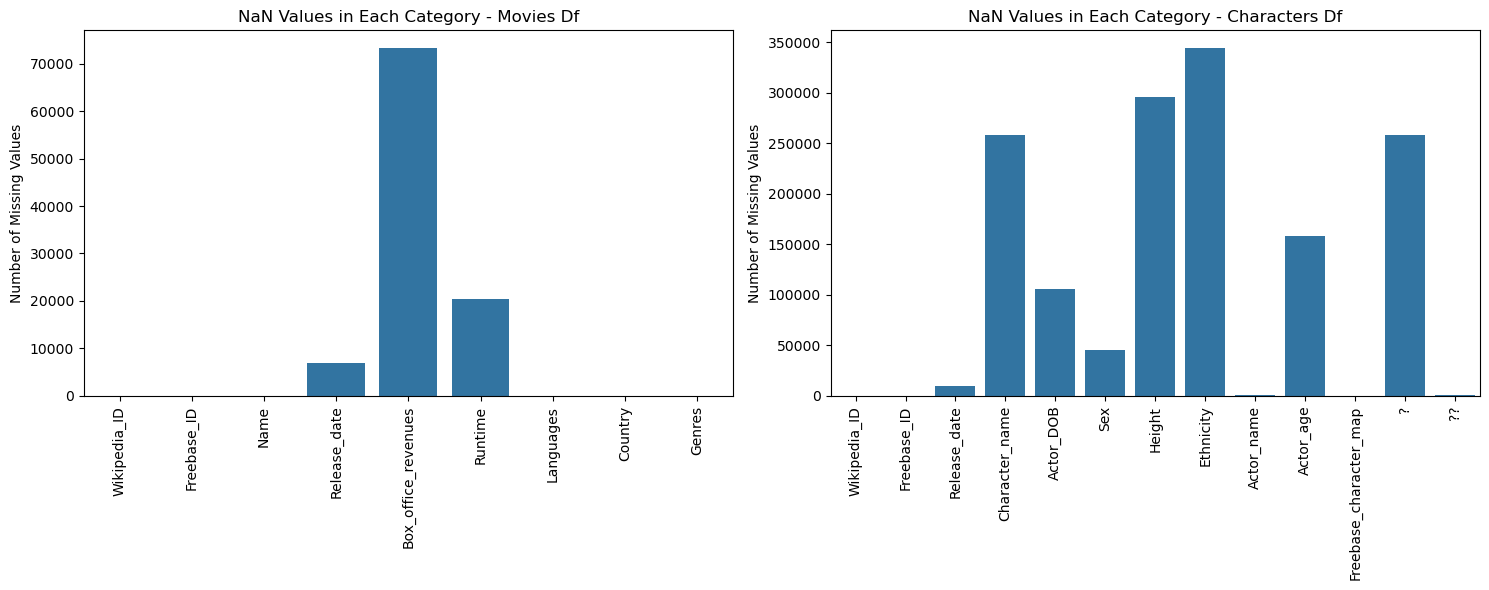

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

missing_values_movies = movies_df.isnull().sum()
missing_values_character = character_df.isnull().sum()

sns.barplot(x=missing_values_movies.index, y=missing_values_movies.values, ax=axs[0])
axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of Missing Values')
axs[0].set_title('NaN Values in Each Category - Movies Df')

# Second subplot (could be modified if you want to show different data or style)
sns.barplot(x=missing_values_character.index, y=missing_values_character.values, ax=axs[1])
axs[1].set_xticklabels(missing_values_character.index, rotation=90)
axs[1].set_xlabel('')
axs[1].set_ylabel('Number of Missing Values')
axs[1].set_title('NaN Values in Each Category - Characters Df')

plt.tight_layout()
plt.show()

Removing Nan Values from Character's names

In [8]:
def remove_nan_rows(df:pd.DataFrame,column:str)->pd.DataFrame:
    no_nan_df = df.dropna(subset=[column])
    return no_nan_df

character_df = remove_nan_rows(character_df,'Character_name')



/var/folders/qy/f2gycl5x4rz0443jgmxn93_80000gn/T/ipykernel_53224/3547849048.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
/var/folders/qy/f2gycl5x4rz0443jgmxn93_80000gn/T/ipykernel_53224/3547849048.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(missing_values_character.index, rotation=90)


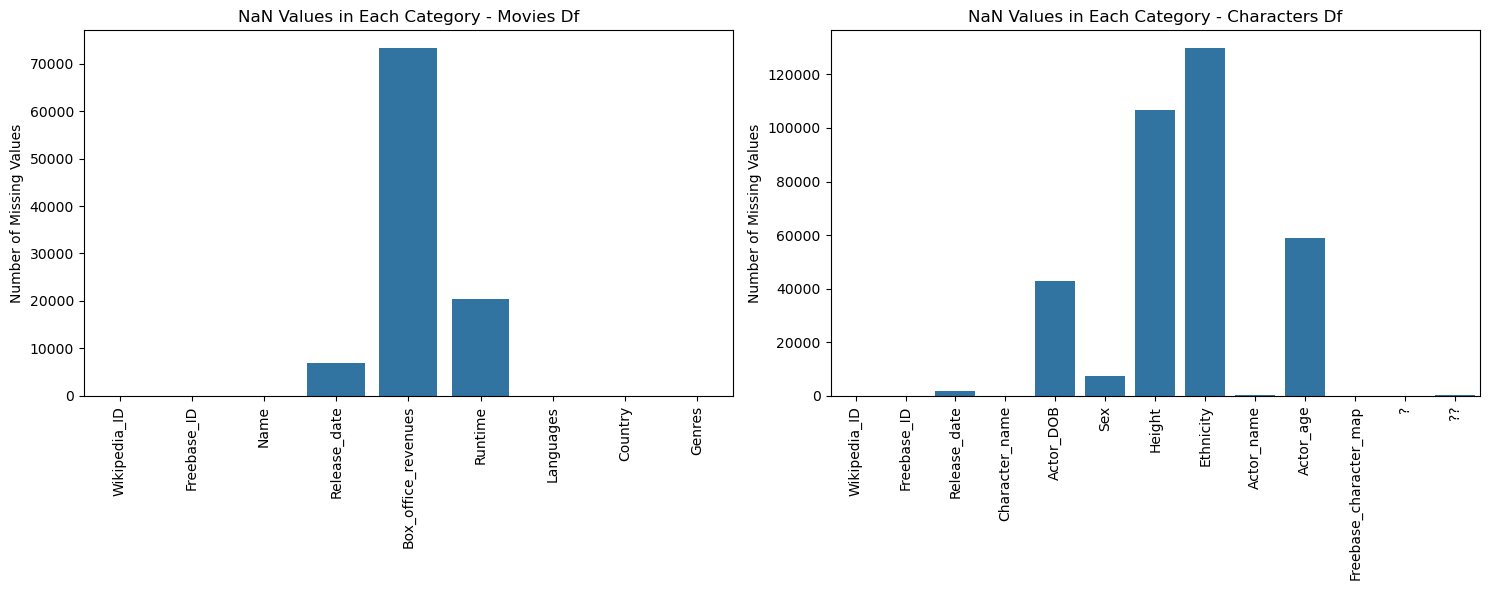

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

missing_values_movies = movies_df.isnull().sum()
missing_values_character = character_df.isnull().sum()

sns.barplot(x=missing_values_movies.index, y=missing_values_movies.values, ax=axs[0])
axs[0].set_xticklabels(missing_values_movies.index, rotation=90)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of Missing Values')
axs[0].set_title('NaN Values in Each Category - Movies Df')

# Second subplot (could be modified if you want to show different data or style)
sns.barplot(x=missing_values_character.index, y=missing_values_character.values, ax=axs[1])
axs[1].set_xticklabels(missing_values_character.index, rotation=90)
axs[1].set_xlabel('')
axs[1].set_ylabel('Number of Missing Values')
axs[1].set_title('NaN Values in Each Category - Characters Df')

plt.tight_layout()
plt.show()

## Common names cleaning

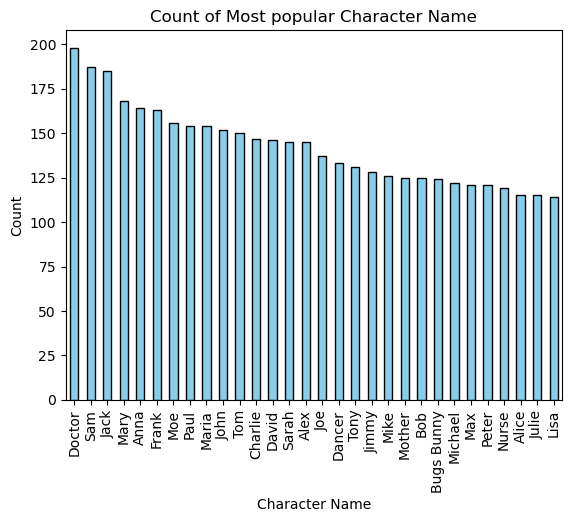

In [10]:
name_counts = character_df['Character_name'].value_counts()

top_names_bar = name_counts.head(30)

top_names_bar.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Name')
plt.ylabel('Count')
plt.title('Count of Most popular Character Name')
plt.show()

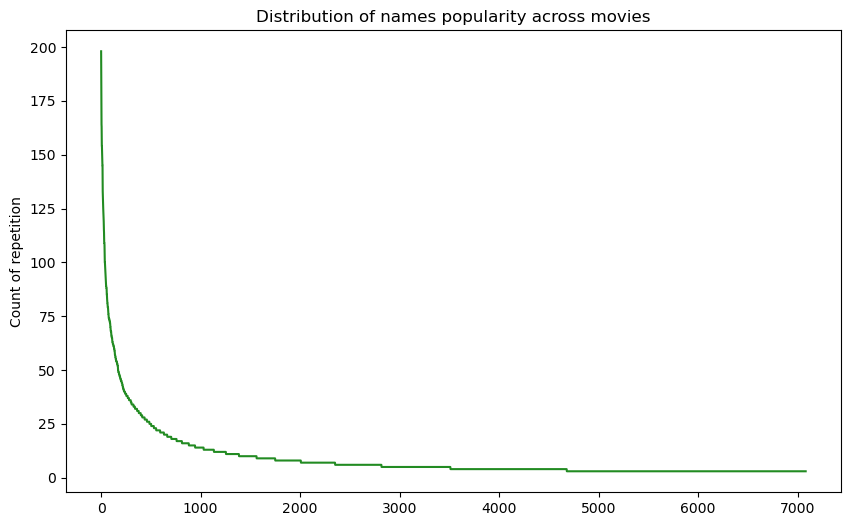

In [11]:
repeated_names = name_counts[name_counts>=3]
plt.figure(figsize=(10, 6))
plt.plot(repeated_names.values, color='forestgreen', linestyle='-', markersize=5)
plt.ylabel("Count of repetition")
plt.title("Distribution of names popularity across movies")
plt.show()

In [12]:
import nltk
nltk.download('words')
from nltk.corpus import words

english_words = set(words.words())
invalid_chars = ['-', '/', '.', ',',"'", '"', '#',"(",')','0','1','2','3','4','5','6','7','8','9']
invalid_word_list = [
    'american', 'british', 'french', 'italian', 'german', 'spanish', 
    'mexican', 'canadian', 'australian', 'japanese', 'russian', 'chinese', 
    'indian', 'brazilian', 'south korean', 'swedish', 'dutch', 'polish', 
    'irish', 'argentine', 'greek', 'egyptian', 'turkish', 'israeli', 
    'south african', 'nigerian', 'filipino', 'indonesian', 'pakistani', 'thai',
    'european', 'asian', 'african', 'le', 'mom', 'la'
]
vowels = set('aeiouy')
def filter_non_english_names(name):
    words_in_name = name.split()

    filtered_words = [
        word for word in words_in_name 
        if word.lower() not in english_words 
        and word.lower() not in invalid_word_list
        and all(char not in word for char in invalid_chars) 
        and any(char in vowels for char in word.lower())
        and sum(1 for char in word if char.isupper()) <= 1
    ]
    return ' '.join(filtered_words)

[nltk_data] Downloading package words to
[nltk_data]     /Users/ainhoavilanova/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [13]:
df_character_filtered = character_df.copy()

df_character_filtered['Character_name']=df_character_filtered['Character_name'].apply(filter_non_english_names)
print(df_character_filtered['Character_name'].shape)

(192794,)


In [14]:
# Showing Deleted Names
values_filtered = df_character_filtered['Character_name'].value_counts()
deleted_names = character_df[df_character_filtered['Character_name']==values_filtered.index[0]]
deleted_names['Character_name'].value_counts().head(10)

Character_name
Doctor    198
Sam       187
Jack      185
Mary      168
Anna      164
Frank     163
Maria     154
Joe       137
Dancer    133
Tony      131
Name: count, dtype: int64

In [15]:
kept_names = df_character_filtered[df_character_filtered['Character_name']!=values_filtered.index[0]]
kept_names.head()

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Jericho,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [16]:
from nltk.corpus import names

# Download the names dataset (only need to do this once)
nltk.download('names')

# Load all names (both male and female) from nltk
all_names = set(names.words())

# Function to check if the name is a first name (male or female)
def keep_names(name):

    name_parts = name.split()
    filtered_names = [
        name for name in name_parts 
        if name in all_names 
    ]
    return ' '.join(filtered_names)

text = 'Joe Paul Antony Toe Mom La'
result = keep_names(text)
print(result)

Joe Paul Antony La


[nltk_data] Downloading package names to
[nltk_data]     /Users/ainhoavilanova/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [17]:
deleted_names_filtered = deleted_names.copy()
deleted_names_filtered['Character_name']=deleted_names_filtered['Character_name'].apply(keep_names)

saved_names = deleted_names_filtered[deleted_names_filtered['Character_name']!='']
print(saved_names.shape)

(22755, 13)


In [18]:
print(kept_names.shape)
kept_names = pd.concat([kept_names, saved_names], ignore_index=True)
kept_names.head()


(137677, 13)


,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Jericho,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [19]:
def keep_first_name(name):
    names = name.split()
    if (len(names)>1):
        name = names[0]
    else:
        name = name
    return name
    
kept_names['Character_name'] = kept_names['Character_name'].apply(keep_first_name)
kept_names.head()

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_DOB,Sex,Height,Ethnicity,Actor_name,Actor_age,Freebase_character_map,?,??
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Melanie,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Jericho,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [20]:
print(kept_names.shape)

(160432, 13)


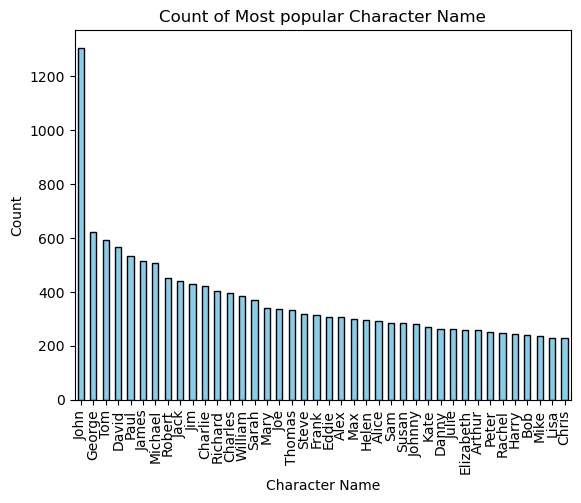

In [21]:
name_counts = kept_names['Character_name'].value_counts()

top_names_bar = name_counts.head(40)

top_names_bar.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Character Name')
plt.ylabel('Count')
plt.title('Count of Most popular Character Name')
plt.show()

## Merging With movie dataset

In [22]:
# Merging the 2 datasets and keeping only interesting features

phonetic_df = pd.merge(movies_df,kept_names, on="Wikipedia_ID",how="inner")[['Wikipedia_ID','Name','Languages','Country','Genres','Character_name','Sex']]

phonetic_df = remove_nan_rows(phonetic_df,'Character_name')
phonetic_df.head()

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex
0,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F
1,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F
2,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M
3,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M
4,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F


## Male/Female names

In [23]:
all_genres = phonetic_df['Genres'].explode().dropna().unique()

# Print the unique genres
print(all_genres.shape)

phonetic_df.columns

(338,)


Index(['Wikipedia_ID', 'Name', 'Languages', 'Country', 'Genres',
       'Character_name', 'Sex'],
      dtype='object')

In [24]:
def categorize_genre(genre_list: list) -> list:
    action_adventure = ['Action', 'Adventure', 'Thriller', 'War film', 'Action/Adventure', 'Martial Arts Film', 'Wuxia', 'Superhero movie', 'Western', 'Sword and sorcery', 'Spy', 'Supernatural']
    drama = ['Drama', 'Biographical film', 'Crime Drama', 'Family Film', 'Family Drama', 'Historical fiction', 'Biopic [feature]', 'Courtroom Drama', 'Political drama', 'Family-Oriented Adventure', 'Psychological thriller']
    comedy = ['Comedy', 'Romantic comedy', 'Comedy-drama', 'Comedy film', 'Black comedy', 'Slapstick', 'Romantic comedy', 'Musical', 'Satire', 'Parody', 'Comedy horror']
    horror_thriller = ['Horror', 'Psychological horror', 'Horror Comedy', 'Slasher', 'Thriller', 'Crime Thriller', 'Sci-Fi Horror', 'Suspense', 'Zombie Film', 'Natural horror films']
    fantasy_sci = ['Fantasy', 'Science Fiction', 'Space western', 'Fantasy Adventure', 'Fantasy Comedy', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Fantasy Drama', 'Dystopia', 'Alien Film', 'Cyberpunk', 'Time travel']
    historical_war = ['Historical drama', 'Historical fiction', 'Historical Epic', 'Epic', 'War effort', 'War film', 'Period piece', 'Courtroom Drama']
    romance = ['Romance Film', 'Romantic drama', 'Romance', 'Romantic fantasy', 'Marriage Drama']
    documentary = ['Documentary', 'Docudrama', 'Biography', 'Historical Documentaries', 'Mondo film', 'Patriotic film', 'Educational']
    music_performance = ['Musical', 'Music', 'Musical Drama', 'Musical comedy', 'Dance', 'Jukebox musical', 'Concert film']
    cult_b_movies = ['Cult', 'B-movie', 'Indie', 'Experimental film', 'Surrealism', 'Avant-garde', 'Grindhouse', 'Blaxploitation', 'Camp']

    categories = []

    for genre in genre_list:
        if genre in action_adventure:
            if 'Action & Adventure' not in categories:
                categories.append('Action & Adventure')
        if genre in drama:
            if 'Drama' not in categories:
                categories.append('Drama')
        if genre in comedy:
            if 'Comedy' not in categories:
                categories.append('Comedy')
        if genre in horror_thriller:
            if 'Horror & Thriller' not in categories:
                categories.append('Horror & Thriller')
        if genre in fantasy_sci:
            if 'Fantasy & Sci-Fi' not in categories:
                categories.append('Fantasy & Sci-Fi')
        if genre in historical_war:
            if 'Historical & War' not in categories:
                categories.append('Historical & War')
        if genre in romance:
            if 'Romance' not in categories:
                categories.append('Romance')
        if genre in documentary:
            if 'Documentary' not in categories:
                categories.append('Documentary')
        if genre in music_performance:
            if 'Music & Performance' not in categories:
                categories.append('Music & Performance')
        if genre in cult_b_movies:
            if 'Cult & B-Movies' not in categories:
                categories.append('Cult & B-Movies')

    return categories if categories else ['Other']

In [25]:
# Apply the fct to reduce the numbers of categories
phonetic_df['Genre_Category'] = phonetic_df['Genres'].apply(lambda x: categorize_genre(x))

In [26]:
genres_list = ['Action & Adventure', 'Drama', 'Comedy', 'Horror & Thriller', 
              'Fantasy & Sci-Fi', 'Historical & War', 'Romance', 'Documentary', 
              'Music & Performance', 'Cult & B-Movies', 'Other']

def get_top_names_by_genre(phonetic_df, genres = genres_list):

    df_male = phonetic_df[phonetic_df['Sex'] == 'M']
    df_female = phonetic_df[phonetic_df['Sex'] == 'F']

    top_male_names_by_genre = {}
    top_female_names_by_genre = {}

    # Loop through each genre and get top names for males and females
    for genre in genres:
        male_genre_names = df_male[df_male['Genre_Category'].apply(lambda categories: genre in categories)]

        top_male_names = male_genre_names['Character_name'].value_counts().head(10).index.tolist()
        top_male_names_by_genre[genre] = top_male_names

        female_genre_names = df_female[df_female['Genre_Category'].apply(lambda categories: genre in categories)]

        top_female_names = female_genre_names['Character_name'].value_counts().head(10).index.tolist()
        top_female_names_by_genre[genre] = top_female_names
    
    # Convert dictionaries to DataFrames with each genre as a column
    frequent_names_m = pd.DataFrame.from_dict(top_male_names_by_genre, orient='index').transpose()
    frequent_names_f = pd.DataFrame.from_dict(top_female_names_by_genre, orient='index').transpose()

    return frequent_names_m, frequent_names_f


frequent_names_m, frequent_names_f = get_top_names_by_genre(phonetic_df)

In [27]:
frequent_names_f.head(10)

,Action & Adventure,Drama,Comedy,Horror & Thriller,Fantasy & Sci-Fi,Historical & War,Romance,Documentary,Music & Performance,Cult & B-Movies,Other
0,Sarah,Sarah,Mary,Sarah,Susan,Elizabeth,Sarah,Elizabeth,Pooja,Mary,Radha
1,Susan,Mary,Sarah,Rachel,Alice,Sarah,Helen,Margaret,Priya,Sarah,Rachel
2,Alice,Helen,Kate,Susan,Sarah,Mary,Elizabeth,Helen,Tina,Helen,Anna
3,Mary,Alice,Julie,Alice,Elizabeth,Anne,Julie,Barbara,Anjali,Kate,Pooja
4,Rachel,Susan,Alice,Karen,Mary,Helen,Mary,Marie,Mary,Rachel,Priya
5,Lisa,Elizabeth,Susan,Helen,Claire,Margaret,Susan,Mary,Julie,Alice,Neha
6,Julie,Kate,Helen,Lisa,Kate,Marie,Kate,Alice,Sonia,Linda,Shanti
7,Kate,Rachel,Elizabeth,Kate,Jane,Alice,Alice,Sarah,Radha,Maggie,Madhu
8,Helen,Julie,Lisa,Elizabeth,Lisa,Charlotte,Marie,Dorothy,Sarah,Lisa,Nisha
9,Elizabeth,Marie,Barbara,Claire,Rachel,Catherine,Maggie,Louise,Anita,Karen,Geeta


In [28]:
frequent_names_m.head(10)

,Action & Adventure,Drama,Comedy,Horror & Thriller,Fantasy & Sci-Fi,Historical & War,Romance,Documentary,Music & Performance,Cult & B-Movies,Other
0,John,John,John,John,John,John,John,John,John,John,John
1,Tom,David,George,Michael,George,William,Paul,George,George,Jack,George
2,James,George,Tom,David,David,George,David,Robert,Paul,Tom,Christmas
3,David,Tom,Paul,Tom,Tom,Robert,George,William,Vijay,David,Mickey
4,George,Paul,Charlie,Paul,James,Charles,Tom,Charles,Joe,George,James
5,Michael,James,Jack,James,Michael,James,Michael,David,Shekhar,Paul,Richard
6,Robert,Michael,Michael,Robert,Robert,Thomas,Richard,Richard,Charlie,Michael,Philip
7,William,Robert,David,George,Charlie,David,Robert,James,Johnny,Jim,Tom
8,Jim,Charles,Moe,Jack,Jack,Richard,Charlie,Paul,Rahul,Charlie,Vijay
9,Paul,Jack,Joe,Richard,William,Tom,James,Tom,David,James,Max


In [29]:
def count_name_appearance_by_genre(df, genres=genres_list, name='Tom'):
    # Filter the DataFrame for the specified name
    df_name = df[df['Character_name'] == name]

    # Initialize genre counts dictionary
    genre_counts = {genre: 0 for genre in genres}

    # Count occurrences by genre
    for _, row in df_name.iterrows():
        row_genres = row['Genre_Category']
        if isinstance(row_genres, list):
            for genre in row_genres:
                if genre in genre_counts:
                    genre_counts[genre] += 1
        else:
            if row_genres in genre_counts:
                genre_counts[row_genres] += 1

    # Convert genre counts to DataFrame
    genre_counts_df = pd.DataFrame([genre_counts])

    return genre_counts_df, df_name

# Example usage
genre_counts_result, movies_with_name = count_name_appearance_by_genre(phonetic_df, genres_list, 'Luca')
print(genre_counts_result.head())
movies_with_name.head(10)

   Action & Adventure  Drama  Comedy  Horror & Thriller  Fantasy & Sci-Fi  \
0                   9     14      10                  5                 3   

   Historical & War  Romance  Documentary  Music & Performance  \
0                 4       10            0                    0   

   Cult & B-Movies  Other  
0                5      1  


,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Genre_Category
10961,31754231,To Rome with Love,"[Italian Language, English Language]","[United States of America, Spain, Italy]","[Romantic comedy, Comedy film, Romance Film]",Luca,M,"[Comedy, Romance]"
16776,348449,Garfield: The Movie,[English Language],[United States of America],"[Family Film, Slapstick, Comedy, Animation]",Luca,M,"[Drama, Comedy]"
19556,21966946,Vertigine d'amore,[Italian Language],"[France, Italy]",[],Luca,M,[Other]
22151,156745,Pretty Woman,"[Japanese Language, Italian Language, English ...",[United States of America],"[Romantic comedy, Romance Film, Comedy]",Luca,F,"[Comedy, Romance]"
23204,24083094,Eat Pray Love,"[Italian Language, Portuguese Language, Englis...",[United States of America],"[Romantic drama, Romance Film, Drama]",Luca,M,"[Romance, Drama]"
25937,281069,Sinbad: Legend of the Seven Seas,"[Italian Language, English Language, Cantonese]",[United States of America],"[Fantasy Adventure, Adventure, Children's/Fami...",Luca,M,"[Fantasy & Sci-Fi, Action & Adventure, Drama]"
30345,17974588,Crows ZERO,[Japanese Language],[Japan],"[Thriller, Action/Adventure, Action, Japanese ...",Luca,F,"[Action & Adventure, Horror & Thriller]"
32483,334874,Shark Tale,[English Language],[United States of America],"[Children's/Family, Computer Animation, Animat...",Luca,M,"[Comedy, Drama]"
33541,10738117,Senso,"[Italian Language, German Language]",[Italy],"[Melodrama, World cinema, History, Period piec...",Luca,M,"[Historical & War, Drama, Action & Adventure, ..."
40166,6545749,Zerophilia,[English Language],[United States of America],"[Romantic comedy, LGBT, Science Fiction, Indie...",Luca,F,"[Comedy, Fantasy & Sci-Fi, Cult & B-Movies, Ro..."


In [30]:
male_count = kept_names[kept_names['Sex'] == 'M'].shape[0]
female_count = kept_names[kept_names['Sex'] == 'F'].shape[0]

print(f"Number of male names: {male_count}")
print(f"Number of female names: {female_count}")

Number of male names: 98027
Number of female names: 56821


In [31]:
def count_vowels(name):
    return sum(1 for char in name.lower() if char in vowels)

consonants = set('bcdfghjklmnpqrstvwxz')
def count_consonants(name):
    return sum(1 for char in name.lower() if char not in vowels)

kept_names['vowel_count'] = kept_names['Character_name'].apply(count_vowels)
kept_names['consonant_count'] = kept_names['Character_name'].apply(count_consonants)

print('Mean number of vowels in name by sex:')
kept_names.groupby('Sex')['vowel_count'].agg(['mean', 'std'])

Mean number of vowels in name by sex:


,mean,std
Sex,,
F,2.633991,0.827407
M,2.305355,0.890816


In [32]:
kept_names['name_length'] = kept_names['Character_name'].apply(lambda name: len(name))
kept_names.groupby('Sex')['name_length'].agg(['mean', 'std'])


,mean,std
Sex,,
F,5.875697,1.671052
M,5.852683,1.853283


In [33]:
kept_names['vowel_percentage'] = kept_names['vowel_count'] / kept_names['name_length']
kept_names['consonant_percentage'] = kept_names['consonant_count'] / kept_names['name_length']

kept_names.groupby('Sex')['vowel_percentage'].agg(['mean', 'std'])

,mean,std
Sex,,
F,0.455882,0.107836
M,0.398126,0.109995


In [34]:
#Regardons pour hommes et femmes séparémeent
kept_names['first_letter'] = kept_names['Character_name'].apply(lambda name: name[0].lower())
first_letter_counts_H = kept_names[kept_names['Sex'] == 'M']['first_letter'].value_counts()
first_letter_counts_F = kept_names[kept_names['Sex'] == 'F']['first_letter'].value_counts()

first_letter_counts_H_percentage = first_letter_counts_H/male_count
first_letter_counts_F_percentage = first_letter_counts_F/female_count

#Let's merge the two series
first_letter_counts = pd.concat([first_letter_counts_H_percentage, first_letter_counts_F_percentage], axis=1)
first_letter_counts = first_letter_counts.head(26)
first_letter_counts.columns = ['first_letter_men', 'first_letter_women']

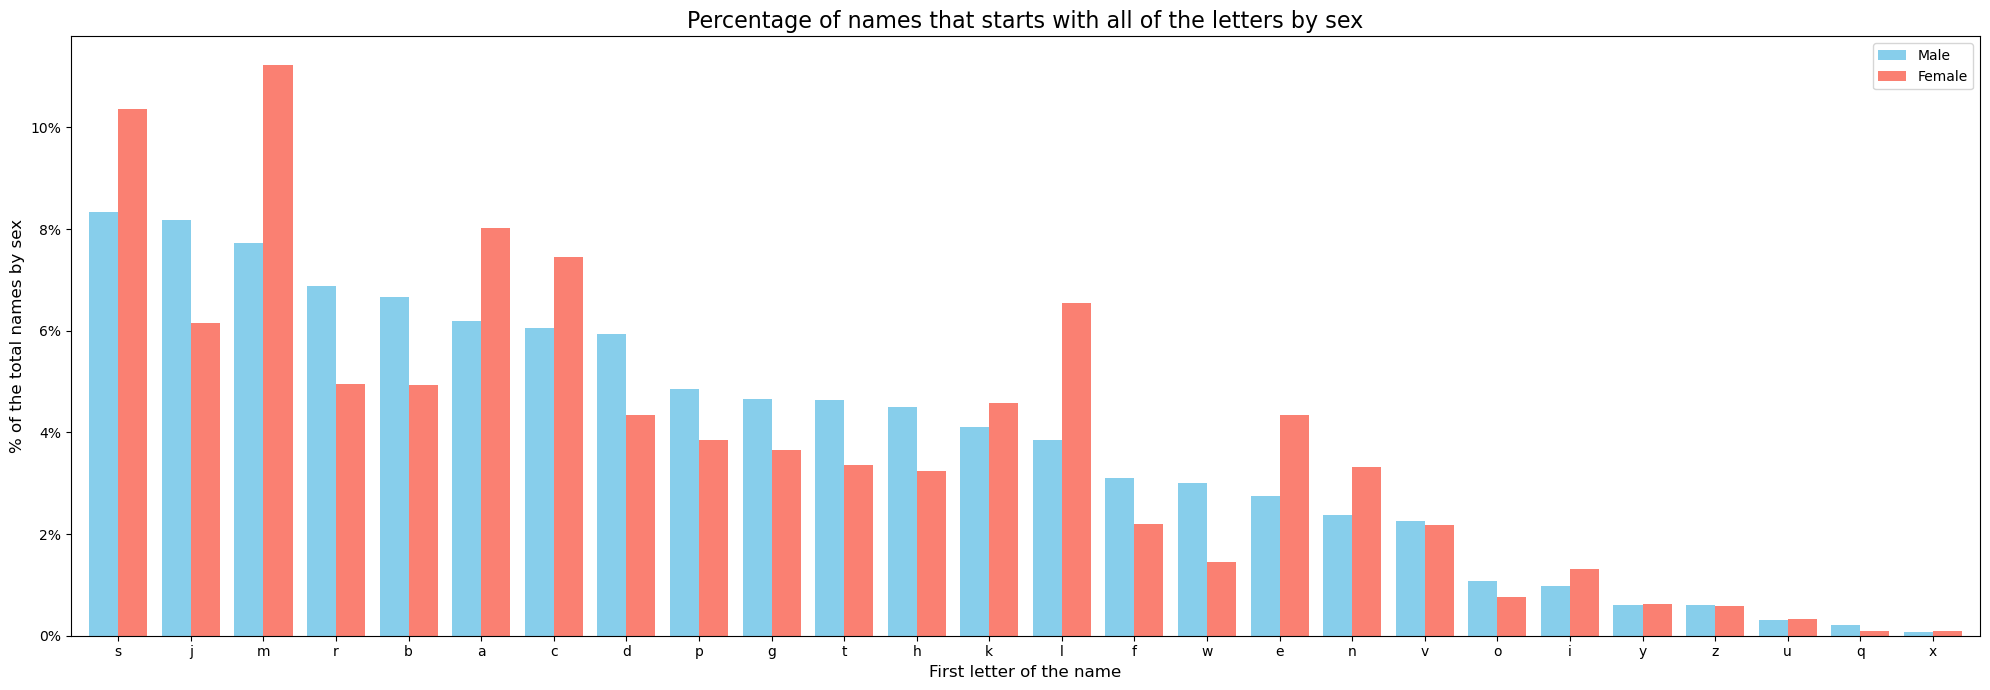

In [35]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(20, 7))

first_letter_counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

ax.set_title('Percentage of names that starts with all of the letters by sex', fontsize=16)
ax.set_xlabel('First letter of the name', fontsize=12)
ax.set_ylabel('% of the total names by sex', fontsize=12)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

ax.legend(['Male', 'Female'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [36]:
# Analyze the last letter of each name for men and women separately
kept_names['last_letter'] = kept_names['Character_name'].apply(lambda name: name[-1].lower())
last_letter_counts_H = kept_names[kept_names['Sex'] == 'M']['last_letter'].value_counts()
last_letter_counts_F = kept_names[kept_names['Sex'] == 'F']['last_letter'].value_counts()

last_letter_counts_H_percentage = last_letter_counts_H/male_count
last_letter_counts_F_percentage = last_letter_counts_F/female_count

# Merge the two series
last_letter_counts = pd.concat([last_letter_counts_H_percentage, last_letter_counts_F_percentage], axis=1)
last_letter_counts = last_letter_counts.head(26)
last_letter_counts.columns = ['last_letter_men', 'last_letter_women']

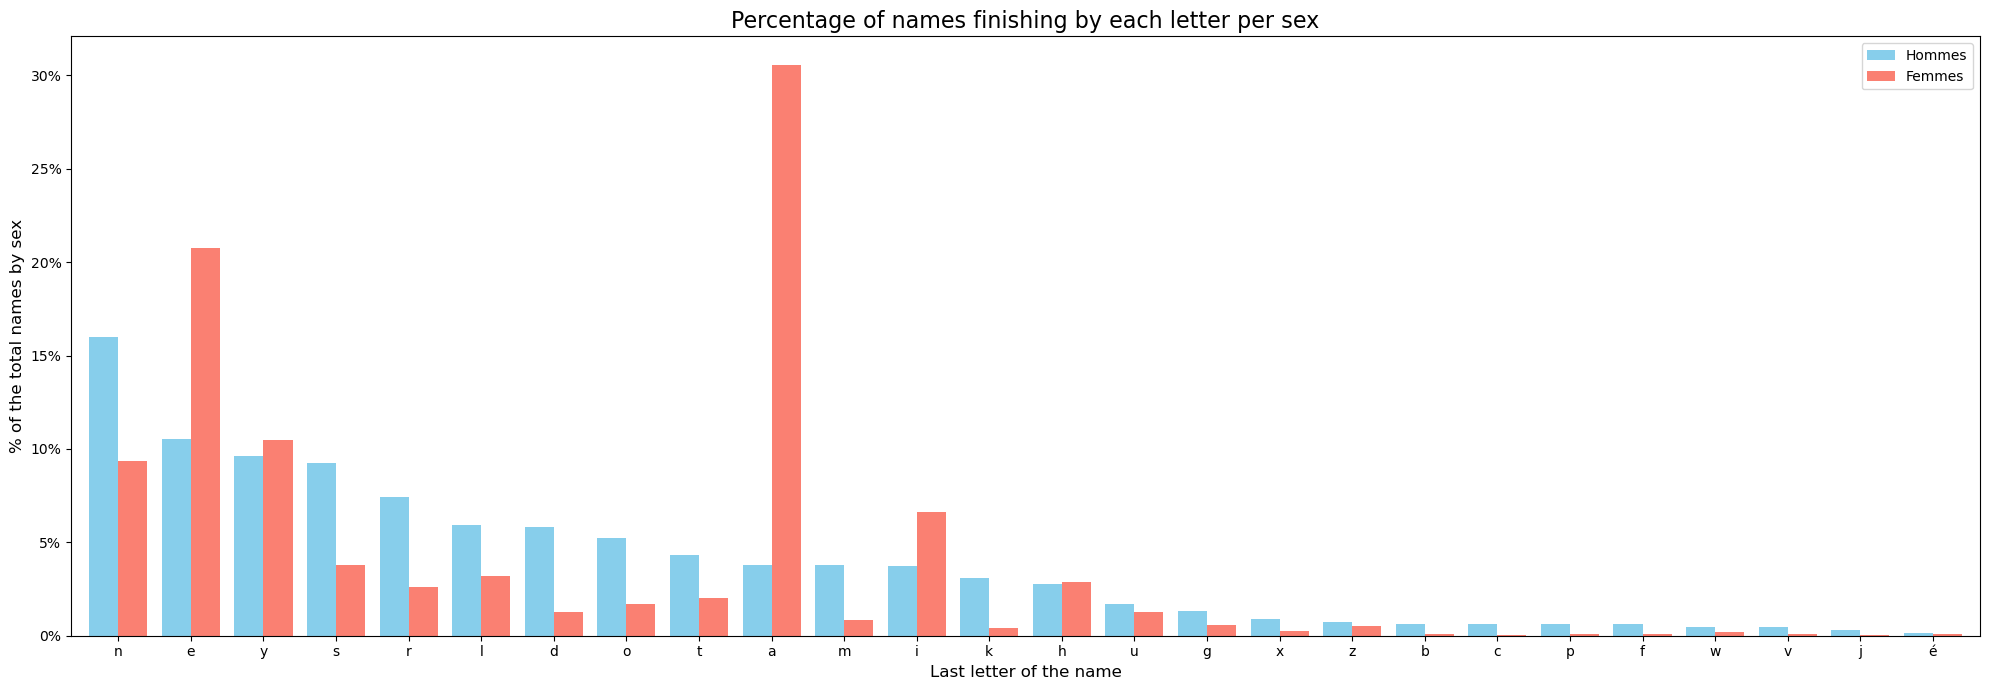

In [37]:
fig, ax = plt.subplots(figsize=(20, 7))

# Tracer les barres pour les hommes et les femmes
last_letter_counts.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'], width=0.8)

# Ajouter les titres et labels
ax.set_title('Percentage of names finishing by each letter per sex', fontsize=16)
ax.set_xlabel('Last letter of the name', fontsize=12)
ax.set_ylabel('% of the total names by sex', fontsize=12)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax.legend(['Hommes', 'Femmes'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Top female/male names for each region


In [38]:
import pycountry
import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        # Get the alpha-2 country code
        country_code = pycountry.countries.lookup(country_name).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_code)

        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except (KeyError, AttributeError, LookupError):
        return None 

In [39]:
phonetic_df['primary_country'] = phonetic_df['Country'].str[0]
phonetic_df['Continent'] = phonetic_df['primary_country'].apply(country_to_continent)
phonetic_df.head(10)

continents = phonetic_df.groupby(['Continent','Sex'])['Character_name'].agg(pd.Series.mode)
df_continents = continents.to_frame().reset_index()
df_continents.columns = ['Continent', 'Sex', 'Name']
df_continents = df_continents.pivot(index='Continent',columns='Sex',values='Name').reset_index()
df_continents.columns = ['Continent', 'Female_name', 'Male_name']
df_continents.head()

,Continent,Female_name,Male_name
0,Africa,"[Amina, Elsa, Miriam, Sandra, Sarah]","[Abraham, Adel, Ahmed, Omar]"
1,Asia,Priya,Vijay
2,Europe,Anna,John
3,North America,Sarah,John
4,Oceania,Angie,John


In [40]:
# for Africa we will pick one of the names to display

df_continents.loc[0,'Female_name'] = 'Amina*'
df_continents.loc[0,'Male_name']='Omar*'

df_continents.head()

,Continent,Female_name,Male_name
0,Africa,Amina*,Omar*
1,Asia,Priya,Vijay
2,Europe,Anna,John
3,North America,Sarah,John
4,Oceania,Angie,John


In [41]:
import plotly.graph_objects as go

coordinates = {
    'Africa': (20, 0),
    'Asia': (90, 40),
    'Europe': (10, 55),
    'North America': (-100, 40),
    'South America': (-60, -15),
    'Oceania': (135, -25),
}

# Prepare data for Scattergeo
names_data = {
    'lon': [],
    'lat': [],
    'text': [],
}

df_continents['Longitude'] = df_continents['Continent'].map(lambda x: coordinates[x][0])
df_continents['Latitude'] = df_continents['Continent'].map(lambda x: coordinates[x][1])

for i, row in df_continents.iterrows():
    names_data['lon'].append(row['Longitude'])
    names_data['lat'].append(row['Latitude'] + 7)  # Slight offset for separation
    names_data['text'].append(f"♂ {row['Male_name']}")
    
    # Female name
    names_data['lon'].append(row['Longitude'])
    names_data['lat'].append(row['Latitude'] - 7)  # Slight offset for separation
    names_data['text'].append(f"♀ {row['Female_name']}")


In [42]:
fig = go.Figure(go.Scattergeo(
    lon=names_data['lon'],
    lat=names_data['lat'],
    text=names_data['text'],
    mode='text',  # Text-only mode
    textfont=dict(size=18, color="black", family="Arial")
))
fig.update_geos(projection_scale=1,center={'lat': 30})
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        showland=True,
        landcolor="lightgrey",
        lakecolor="aqua",
    ),
    height=500,
    margin={"r":0,"t":5,"l":0,"b":0},
    title="Most Common Male and Female Names by Continent"
)
fig.show()

## Proportion of movies per country per continent

In [43]:
proportion_country = phonetic_df.groupby(['Continent', 'primary_country'])['primary_country'].count()
df_proportion = proportion_country.to_frame()
df_proportion.columns = ['Number_of_movies']
df_proportion = df_proportion.reset_index()
df_proportion['Prop_of_movies'] = df_proportion['Number_of_movies']/df_proportion['Continent'].sum('')
df_proportion.head(20)

ValueError: No axis named  for object type Series

In [ ]:
import plotly.express as px
fig = px.treemap(df_proportion,path=[px.Constant("world"), 'Continent', 'primary_country'],values='Number_of_movies')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

NameError: name 'df_proportion' is not defined

We can see that every sub-dataset for each continent is very unbalanced. In Asia for example 

In [44]:
from wordcloud import WordCloud
from pywaffle import Waffle

df_thriller = phonetic_df[phonetic_df['Genres'].apply(lambda genres: 'Thriller' in genres if isinstance(genres, list) else False)]

count_top_names = df_thriller['Character_name'].value_counts().head(20)
tot_top_names = count_top_names.sum()
print(tot_top_names)
count_names = df_thriller['Character_name'].value_counts().sum()
print(count_names)
number_names = len(df_thriller['Character_name'].unique())
print("tot names:",number_names)
names = count_top_names.index.tolist()
values = count_top_names.values.tolist()



2529
33244
tot names: 11067


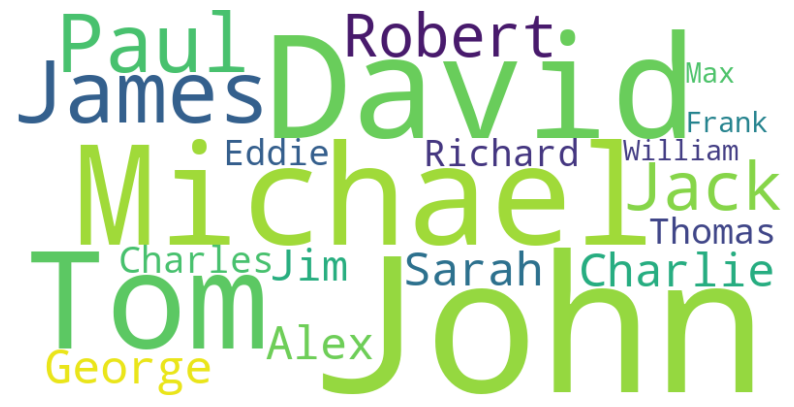

In [45]:
from wordcloud import WordCloud

# Generate a word cloud from the counts
wordcloud = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1, collocations=False).generate_from_frequencies(count_top_names)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# N-gram Analysis

In [46]:

phonetic_df['Phonetic'] = phonetic_df['Character_name'].apply(lambda x: doublemetaphone(x)[0])
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
char_ngrams = vectorizer.fit_transform(phonetic_df['Character_name'])



In [47]:
# We create a Dataframe with the n-gram features
ngram_df = pd.DataFrame(char_ngrams.toarray(), columns=vectorizer.get_feature_names_out())
ngram_df = ngram_df.astype('float32') # converting to float32 to decrease the computing time

ngram_df.shape # We see that the dimentionality of ngram is very high, potentially increasing exponentially the processing time, we will deal with that later

(160432, 10186)

In [ ]:
#le = LabelEncoder()
#phonetic_df['origin_encoded'] = le.fit_transform(phonetic_df['Country'].str[0])
#print(phonetic_df.shape)


In [48]:
# We use minibatch kmeans clustering becease is more efficient for larger datasets
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=1000, random_state=42) 
phonetic_df['cluster'] = kmeans.fit_predict(ngram_df)


Le code juste en dessous prend 5 min a run


In [49]:
# PREND 5 min A RUN

# To reduce n-gram dimentionality we use PCA
ipca = IncrementalPCA(n_components=3, batch_size=500)
pca_result = ipca.fit_transform(ngram_df)




In [50]:
loadings = pd.DataFrame(ipca.components_.T, columns=[f'PC{i+1}' for i in range(ipca.n_components_)], index=ngram_df.columns)

loadings['PC1']=loadings['PC1'].apply(abs)

print(loadings['PC1'].nlargest(10))

an     0.837175
ra     0.155166
nd     0.152878
ha     0.152112
and    0.148026
er     0.131844
na     0.118500
han    0.116221
ran    0.100093
ma     0.092794
Name: PC1, dtype: float64


En gros le n-gram decisif qui permet de séparer le plus les noms en clusters c'est "an" (et de loin). 
J'ai aucune idée de comment interpreter ca ???

## N-gram pour les pays

In [53]:
df_country = phonetic_df.copy()
df_country['pca_one'] = pca_result[:, 0]
df_country['pca_two'] = pca_result[:, 1]
df_country['pca_three'] = pca_result[:, 2]

ValueError: Could not interpret value `continent` for `hue`. An entry with this name does not appear in `data`.

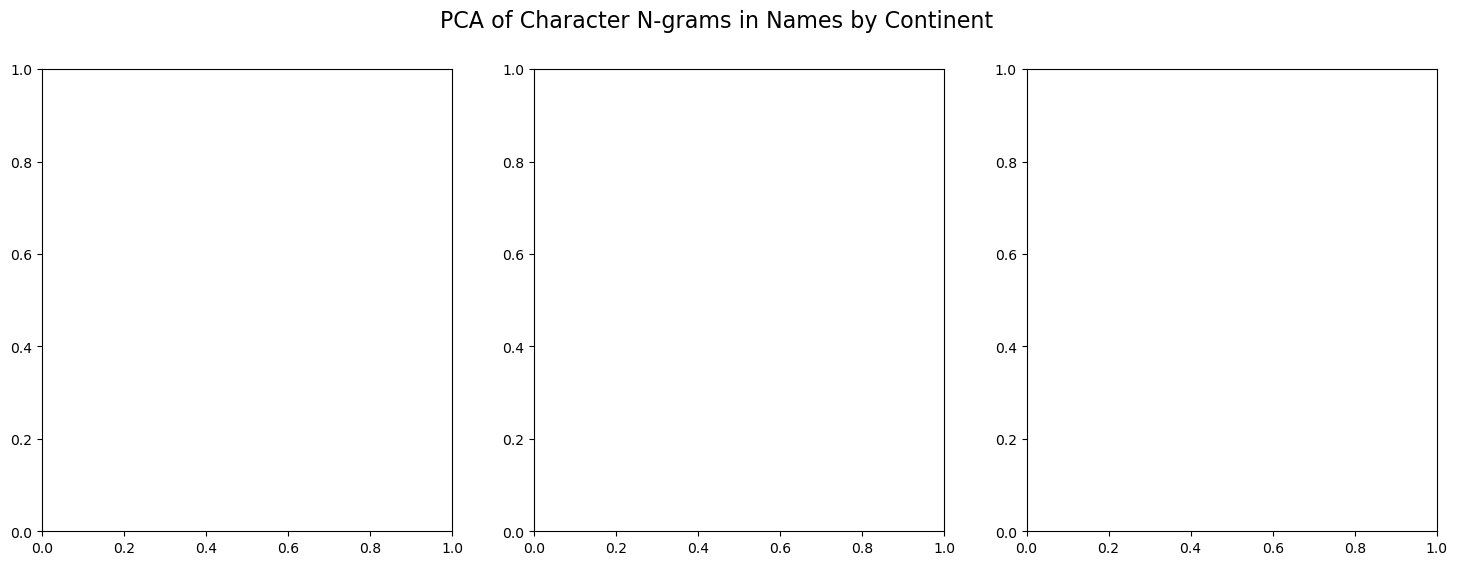

In [54]:



# Visualization
palette = ['#de324c','#f4895f','#f8e16f','#95cf92','#369acc','#9656a2']
fig,axs = plt.subplots(1,3,figsize=(18, 6))
fig.suptitle("PCA of Character N-grams in Names by Continent", fontsize=16)

sns.scatterplot(x="pca_one", y="pca_two", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[0])
sns.scatterplot(x="pca_one", y="pca_three", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[1])
sns.scatterplot(x="pca_two", y="pca_three", hue="continent", data=df_country, palette=palette, size=2,linewidth=0.3, ax=axs[2])
plt.title("PCA of Character N-grams in Names by Continent")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



Même si y'a pas de claire division entre les continents on voit que l'Asie a des noms avec des n-grams un peu different par rapport aux autres continent

## Ngram pour les genres

In [55]:
df_genre = phonetic_df.copy()
df_genre['pca_one'] = pca_result[:, 0]
df_genre['pca_two'] = pca_result[:, 1]

In [56]:
top_genres=df_genre['Genres'].explode().value_counts().head(11)
print(top_genres)

Genres
Drama               90677
Comedy              48601
Romance Film        34544
Thriller            33244
Action              27574
Crime Fiction       22287
World cinema        17707
Adventure           17195
Indie               15799
Action/Adventure    15534
Family Film         13353
Name: count, dtype: int64


In [57]:
def top_genre_search(genres:list[str]):
    for genre in genres:
        if genre in top_genres:
            return genre         
    return 'other'
        
df_genre['top_genre'] = df_genre['Genres'].apply(top_genre_search)


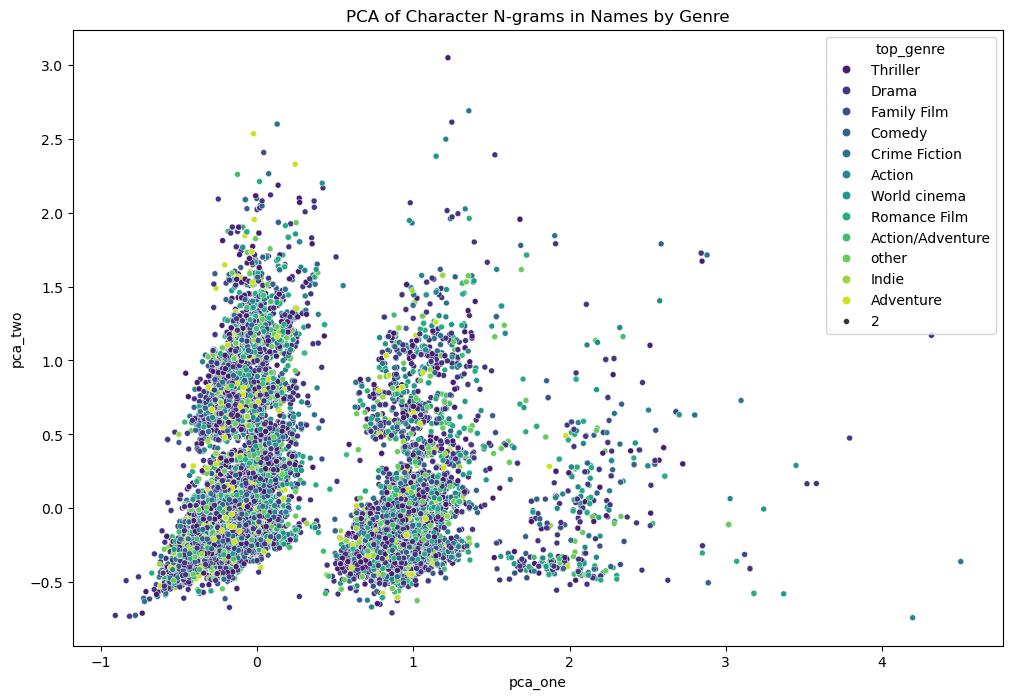

In [58]:

plt.figure(figsize=(12, 8))
sns.scatterplot(x="pca_one", y="pca_two", hue="top_genre", data=df_genre, palette="viridis", size=2,linewidth=0.3)
plt.title("PCA of Character N-grams in Names by Genre")
plt.show()

Tout est mélangé 

## Phonetics

In [64]:
phonetic_df.head()

,Wikipedia_ID,Name,Languages,Country,Genres,Character_name,Sex,Genre_Category,primary_country,Continent,Phonetic,cluster
0,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Akooshay,F,"[Action & Adventure, Horror & Thriller, Fantas...",United States of America,North America,AKX,7
1,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Melanie,F,"[Action & Adventure, Horror & Thriller, Fantas...",United States of America,North America,MLN,8
2,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Williams,M,"[Action & Adventure, Horror & Thriller, Fantas...",United States of America,North America,ALMS,7
3,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Jericho,M,"[Action & Adventure, Horror & Thriller, Fantas...",United States of America,North America,JRX,2
4,975900,Ghosts of Mars,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",Bashira,F,"[Action & Adventure, Horror & Thriller, Fantas...",United States of America,North America,PXR,7


In [71]:
from fuzzy import DMetaphone

# Initialize Double Metaphone instance
dmeta = DMetaphone()

# Function to generate codes for each name
def get_dmetaphone_code(name):
    name = str(name)  # Ensure name is handled as Unicode
    codes = dmeta(name)
    return codes[0], codes[1]  # primary and secondary codes

# List of names
names = phonetic_df['Character_name'].tolist()

print(names[2])

# Dictionary to store names and their Double Metaphone codes
#name_codes = {name: get_dmetaphone_code(name) for name in names}

# Function to find matching names based on Double Metaphone codes
def find_similar_names(input_name):
    input_codes = get_dmetaphone_code(input_name)
    similar_names = [
        name for name, codes in name_codes.items()
        if input_codes[0] == codes[0] or input_codes[1] == codes[1]
    ]
    return similar_names




Williams
